In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import smplotlib
from numpy.random import *
import secrets

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
import time

In [2]:
seed = secrets.randbits(128)
rng_default = np.random.default_rng(seed)

#### Plummer model:

\begin{equation}
    \rho_{\rm P}(r) = \left( \frac{3M}{4\pi r_o^3} \right) \left( 1 + \frac{r^2}{r_o^2} \right)^{-5/2}.
\end{equation}

This function was introduced by Henry C. Plummer at the beginning of the XX century to describe the density profile of globular clusters.
$M$ is the total mass and $r_o$ is a characteristic length called the core radius.
It is important in $N$-body simulations because it corresponds to a smoothed
point mass potential.

A dimensionless version of this model:
\begin{equation}
    \delta_{\rm P} = \left( 1 + \eta^2 \right)^{-5/2},
\end{equation}
where
\begin{equation}
    \eta \equiv r/r_o, ~~ {\rm and} ~~ \rho_{\rm P}(\eta) = \frac{3M}{4\pi r_o^3} \delta_{\rm P}(\eta).
\end{equation}

The cumulative distribution function is
\begin{equation}
    4\pi \int_0^\eta s^2 \delta_{\rm P}(s)ds = \frac{4\pi}{3} \frac{\eta^3}{(1+\eta^2)^{3/2}} \rightarrow \frac{4\pi}{3},~~ {\rm and} ~~ \eta \rightarrow \infty.
\end{equation}

We define the normalized cumulative distribution function as
\begin{equation}
    \mu_{\rm P}(\eta) \equiv \frac{\eta^3}{(1+\eta^2)^{3/2}},
\end{equation}
whose inverse is
\begin{equation}
    \eta = \sqrt{\frac{\mu_{\rm P}^{2/3}}{1-\mu_{\rm P}^{2/3}}}.
\end{equation}

In [3]:
def delta_P(eta):
    return np.power(1.0+np.square(eta), -2.5)

def mu_P(eta):
    return np.power(eta, 3) * np.power((1.0+np.square(eta)), -1.5)

def mu_P_inv(mu_):
    mup = np.power(mu_, 2.0/3.0)
    return np.sqrt(mup/(1.0-mup))

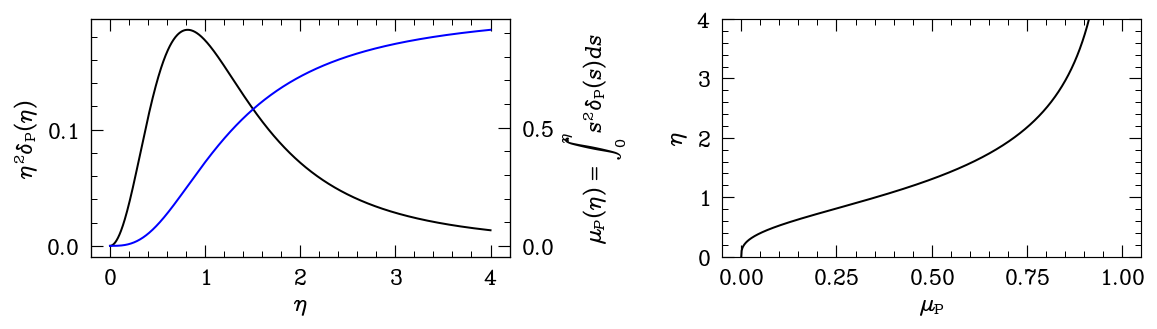

In [4]:
eta = np.linspace(0.0, 4.0, 1000)
mu_P_ = np.linspace(0.0, 1.0, 1000)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\eta^2\delta_{\rm P}(\eta)$')
ax.plot(eta, delta_P(eta)*eta**2)

axx = ax.twinx()
axx.set_ylabel(r"$\mu_P(\eta)=\int_{0}^\eta s^2 \delta_{\rm P}(s)ds$")
axx.plot(eta, mu_P(eta), c='b')

ax2.set_xlabel(r'$\mu_{\rm P}$')
ax2.set_ylabel(r'$\eta$')
ax2.plot(mu_P_, mu_P_inv(mu_P_))
ax2.set_ylim(0, 4)

plt.tight_layout()

### 1) Write a program that generates random realizations of a Plummer sphere (positions only).

We need
\begin{equation}
    f_r(r)\propto r^2\delta_{\rm P}(r), ~~~~~ f_\theta(\theta) \propto \sin \theta,~~{\rm and} ~~~~~ f_\phi(\phi) \propto 1,
\end{equation}
such that
\begin{equation}
    f_r(r) f_\theta (\theta) f_\phi(\phi) dr d\theta d\phi = f(r) r^2 \sin \theta dr d\theta d\phi
\end{equation}

Then,
\begin{equation}
    F'_\theta (\theta) \equiv \int_0^\theta f_\theta(t)dt = \int_0^\theta \sin(t)dt = 1 - \cos \theta,
\end{equation}
but $F'(\pi)=2$. Hence, we renormalize and
\begin{equation}
    F_\theta (\theta) = \frac{1}{2} \left(1 - \cos \theta \right).
\end{equation}
The inverse is
\begin{equation}
    \theta = \arccos \left( 1-2F_\theta \right).
\end{equation}

In [5]:
def RandomPlummer_r(N, rng=rng_default):
    mu_P_ = rng.random(N)
    return mu_P_inv(mu_P_)

def Random_th(N, rng=rng_default):
    F_ = rng.random(N)
    return np.arccos(1.0-2.0*F_)

def Random_phi(N, rng=rng_default):
    return 2*np.pi*rng.random(N)

def Random_sphere(N, rng=rng_default):
    return np.array([Random_th(N, rng), Random_phi(N, rng)]).transpose()

def RandomPlummer(N, rng=rng_default):
    Rp_r = RandomPlummer_r(N, rng).reshape((N, 1))
    result = np.zeros((N, 3))
    result[:,0] = RandomPlummer_r(N, rng)
    result[:,1:] = Random_sphere(N, rng)
    return result

def Random_sphere_cart(N, rng=rng_default):
    Polar = Random_sphere(N, rng)
    th = Polar[:,0]
    ph = Polar[:,1]
    sth = np.sin(th)
    x = sth * np.cos(ph)
    y = sth * np.sin(ph)
    z = np.cos(th)
    return np.array([x, y, z]).transpose()

def Random_sphere_RF(N, rng=rng_default):
    z = rng.uniform(-1.0, 1.0, N)
    ph = rng.uniform(0.0, 2*np.pi, N)
    sth = np.sqrt((1.0 - z) * (1.0 + z))
    x = sth * np.cos(ph)
    y = sth * np.sin(ph)
    return np.array([x, y, z]).transpose()

def Random_sphere_Gaussian(N, rng=rng_default):
    x = rng.normal(size=N)
    y = rng.normal(size=N)
    z = rng.normal(size=N)
    r = np.sqrt(x*x+y*y+z*z)
    x /= r
    y /= r
    z /= r
    return np.array([x, y, z]).transpose()

def Random_sphere_Gaussian_WRONG(N, rng=rng_default):
    x = rng.uniform(-1, 1, N)
    y = rng.uniform(-1, 1, N)
    z = rng.uniform(-1, 1, N)
    r = np.sqrt(x*x+y*y+z*z)
    x /= r
    y /= r
    z /= r
    return np.array([x, y, z]).transpose()

In [6]:
N = 100
start = time.time()
Random_sphere_cart(N)
end = time.time()
print(end-start)

start = time.time()
Random_sphere_RF(N)
end = time.time()
print(end-start)

start = time.time()
Random_sphere_Gaussian(N)
end = time.time()
print(end-start)

0.00012421607971191406
7.700920104980469e-05
0.0001761913299560547


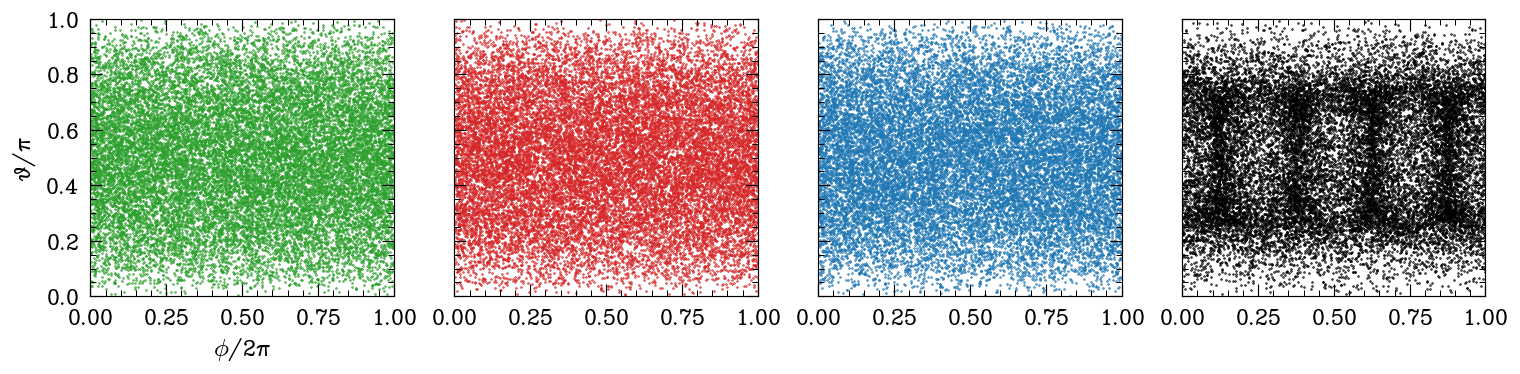

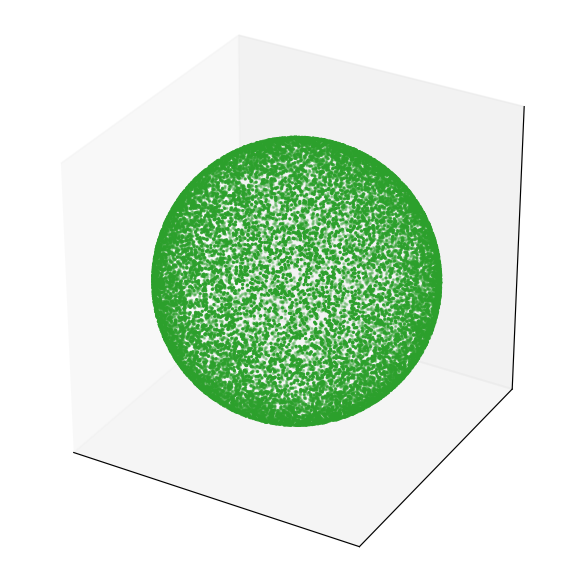

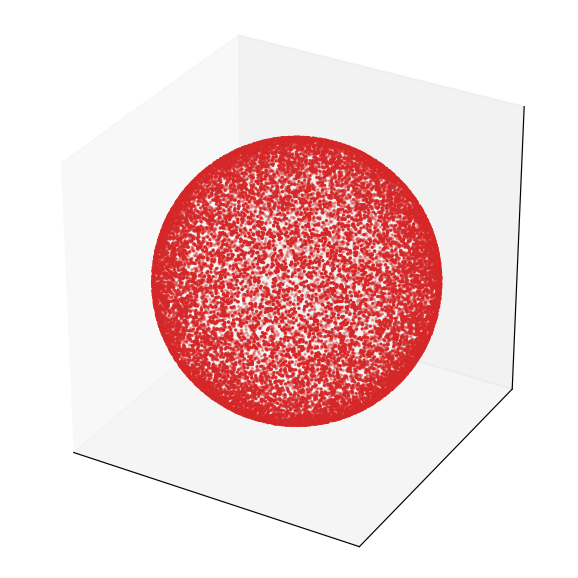

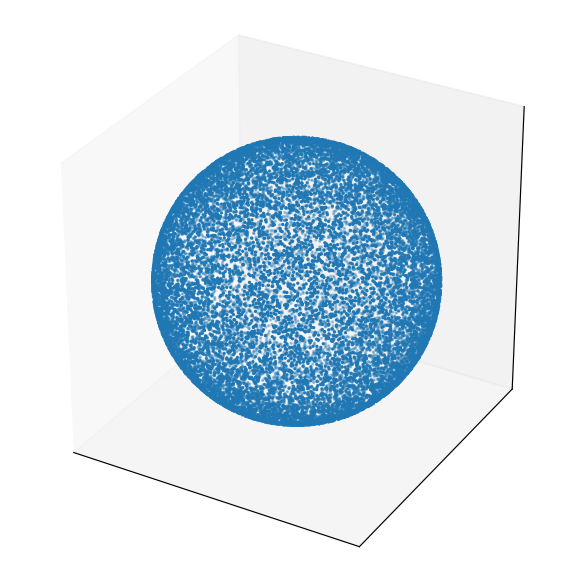

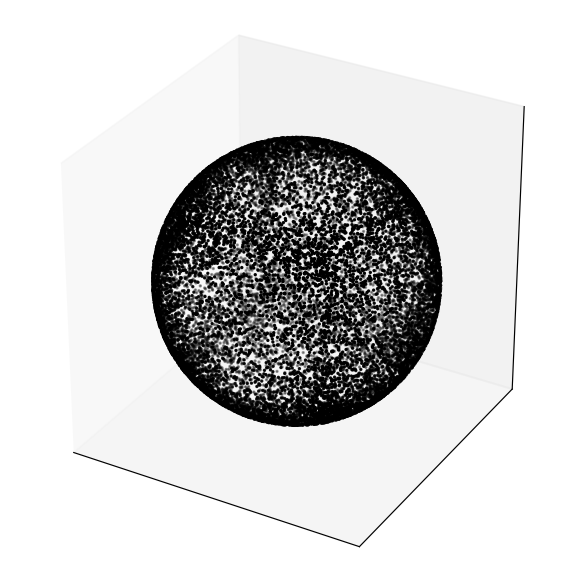

In [12]:
N = 20000

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 3), sharey=True)

ax1.set_xlabel(r'$\phi/2\pi$')
ax1.set_ylabel(r'$\theta/\pi$')
ax1.set_ylim(0, 1)
ax1.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax4.set_xlim(0, 1)

Points = Random_sphere(N)
th = Points[:,0]
ph = Points[:,1]
ax1.scatter(ph/(2*np.pi), th/np.pi, s=0.2, color='tab:green')

Points = Random_sphere_RF(N)
x = Points[:,0]
y = Points[:,1]
z = Points[:,2]
th = np.arccos(z)
ph = np.arctan2(y, x) + np.pi
ax2.scatter(ph/(2*np.pi), th/np.pi, s=0.2, color='tab:red')

Points = Random_sphere_Gaussian(N)
x = Points[:,0]
y = Points[:,1]
z = Points[:,2]
th = np.arccos(z)
ph = np.arctan2(y, x) + np.pi
ax3.scatter(ph/(2*np.pi), th/np.pi, s=0.2, color='tab:blue')

Points = Random_sphere_Gaussian_WRONG(N)
x = Points[:,0]
y = Points[:,1]
z = Points[:,2]
th = np.arccos(z)
ph = np.arctan2(y, x) + np.pi
ax4.scatter(ph/(2*np.pi), th/np.pi, s=0.2, color='k')


fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

Points = Random_sphere(N)
th = Points[:,0]
ph = Points[:,1]
x = np.sin(th) * np.cos(ph)
y = np.sin(th) * np.sin(ph)
z = np.cos(th)
# ax.plot_surface(x, y, Z, color='c', alpha=0.3, edgecolor='k')

# Scatter points
ax.scatter(x, y, z, color='tab:green', s=1)

# Adjust view
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

Points = Random_sphere_RF(N)
x = Points[:,0]
y = Points[:,1]
z = Points[:,2]
# ax.plot_surface(x, y, Z, color='c', alpha=0.3, edgecolor='k')

# Scatter points
ax.scatter(x, y, z, color='tab:red', s=1)

# Adjust view
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

Points = Random_sphere_Gaussian(N)
x = Points[:,0]
y = Points[:,1]
z = Points[:,2]
# ax.plot_surface(x, y, Z, color='c', alpha=0.3, edgecolor='k')

# Scatter points
ax.scatter(x, y, z, color='tab:blue', s=1)

# Adjust view
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

Points = Random_sphere_Gaussian_WRONG(N)
x = Points[:,0]
y = Points[:,1]
z = Points[:,2]
# ax.plot_surface(x, y, Z, color='c', alpha=0.3, edgecolor='k')

# Scatter points
ax.scatter(x, y, z, color='k', s=1)

# Adjust view
ax.set_box_aspect([1, 1, 1])  # Equal aspect ratio
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plt.show()

### 2) Write separately a routine that generates radial coordinates, and another that generates random points on the unit sphere. Combine the results to generate cartesian coordinates for each point.

In [8]:
def RandomPlummerCart(N, rng=rng_default):
    Points = RandomPlummer(N, rng)
    r_ = Points[:,0]
    th_ = Points[:,1]
    ph_ = Points[:,2]

    x = r_ * np.sin(th_) * np.cos(ph_)
    y = r_ * np.sin(th_) * np.sin(ph_)
    z = r_ * np.cos(th_)
    return np.array([x, y, z]).transpose()

### 3) Make a plot of the theoretical radial density profile vs. a histogram of the radial distribution of particles, normalized to the volume of the spherical shell used for each radial bin.

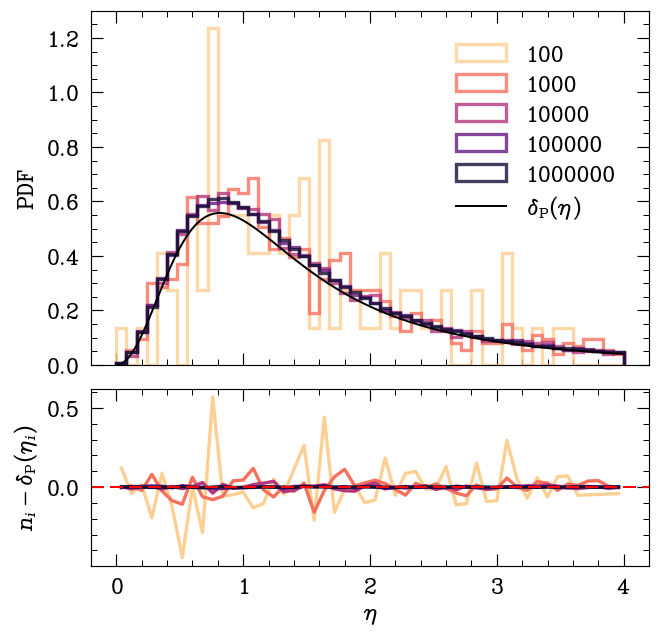

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

N = np.geomspace(100, 1e6, 5, dtype=np.int32)
nbins = 50

cmap = mpl.cm.get_cmap('magma_r')
colors = cmap(np.linspace(0.1, 0.9, len(N)))

for i, Ni in enumerate(N):
    etai = RandomPlummer_r(Ni)
    ni, bins = np.histogram(etai, bins=nbins, range=(0, 4))
    bins_centered = 0.5*(bins[:-1] + bins[1:])
    FracDiff = ni / (Ni * np.diff(bins)) - bins_centered**2*delta_P(bins_centered)*3
    
    ax1.hist(etai, bins=nbins, range=(0, 4), color=colors[i], density=True, label=str(Ni), alpha=0.8, histtype='step', lw=2)
    ax2.plot(bins_centered, FracDiff, color=colors[i], lw=2)

ax1.plot(eta, eta**2*delta_P(eta)*3, label=r'$\delta_{\rm P}(\eta)$')
ax1.set_ylabel(r'PDF')
ax1.legend()
ax2.set_ylabel(r'$n_i - \delta_{\rm P}(\eta_i)$')
ax2.axhline(0.0, c='r', ls='--')
ax2.set_xlabel(r'$\eta$')

plt.subplots_adjust(hspace=0.09)

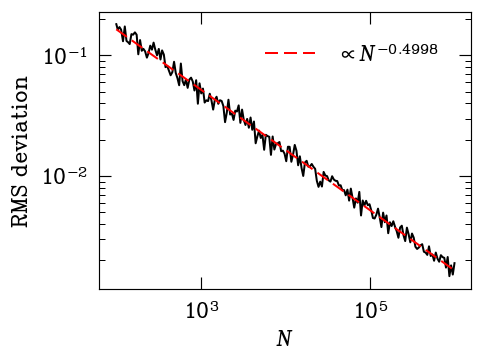

In [10]:
N = np.geomspace(100, 1e6, 200, dtype=np.int32)
RMSdev = np.zeros(len(N))

for i, Ni in enumerate(N):
    etai = RandomPlummer_r(Ni)
    ni, bins = np.histogram(etai, bins=nbins, range=(0, 4))
    bins_centered = 0.5*(bins[:-1] + bins[1:])
    FracDiff = ni / (Ni * np.diff(bins)) - bins_centered**2*delta_P(bins_centered)*3
    RMSdev[i] = np.sqrt(1.0/nbins * np.sum(np.square(FracDiff)))

def FE_fit(N, A, alpha):
    return A * np.power(N, -alpha)

def logFE_fit(logN, A, alpha):
    return A - alpha * logN

popt, pcov = curve_fit(logFE_fit, np.log(N), np.log(RMSdev))

fig, ax = plt.subplots(figsize=(4, 3))

ax.set_xlabel(r'$N$')
ax.set_ylabel(r'RMS deviation')
ax.loglog(N, RMSdev)
ax.loglog(N, np.exp(logFE_fit(np.log(N), *popt)), ls='--', c='r', label=r'$\propto N^{' + "{:.4f}".format(-popt[1]) + '}$')

ax.legend()